# Testing Sentinel 2 dynamic cloud mask

**License:** Code freely available under the [Apache License, Version 2.0](https://www.apache.org/licenses/LICENSE-2.0).

**Contact:** If you find an issue with this notebook or need assistance, please post a question on the [OpenDataCube slack channel](https://opendatacube.slack.com), ask a question on StackExchange using the [open-data-cube tag](https://gis.stackexchange.com/questions/tagged/open-data-cube), or file an issue on [Github](https://github.com/GeoscienceAustralia/dea-notebooks).

**Last modified:** August 2019

### Description
Testing the newly developed Sentinel-2 temporal cloudmask

## Load modules

In [1]:
import datacube
import matplotlib.pyplot as plt
import xarray as xr

dc = datacube.Datacube()
dc_cloudmask = datacube.Datacube(config='/home/561/rt1527/s2_temporalcloudmask.conf')

## Load in temporal cloud mask and fmask


In [2]:
dc_cloudmask.list_measurements().loc['s2_tsmask']

,name,dtype,units,nodata,aliases,flags_definition,spectral_definition
measurement,,,,,,,
classification,classification,uint8,1,1,NaN,"{'classification': {'bits': [0, 1, 2, 3, 4, 5,...",NaN


In [17]:
# Set up query 
query = dict(y=(-35.28, -35.34),   
             x=(149.12, 149.18),
             time=('2018-08', '2019-08'),
             output_crs='EPSG:3577', 
             resolution=(-20, 20))
        
# Load in temporal cloudmask data
tsmask_ds = dc_cloudmask.load(product='s2_tsmask', **query)

# Load in Sentinel 2A and 2B fmask
s2a_ds = dc.load(product='s2a_ard_granule', 
                 measurements=['fmask', 'nbart_red', 'nbart_green', 'nbart_blue'], 
                 **query)
s2b_ds = dc.load(product='s2b_ard_granule', 
                 measurements=['fmask', 'nbart_red', 'nbart_green', 'nbart_blue'], 
                 **query)
s2_ds = xr.concat([s2a_ds, s2b_ds], dim='time').sortby('time')


In [4]:
print(tsmask_ds)

<xarray.Dataset>
Dimensions:         (time: 142, x: 316, y: 368)
Coordinates:
  * time            (time) datetime64[ns] 2018-08-28T00:02:41.024000 ... 2019-08-18T00:02:49.024000
  * y               (y) float64 -3.957e+06 -3.957e+06 ... -3.965e+06 -3.965e+06
  * x               (x) float64 1.549e+06 1.549e+06 ... 1.555e+06 1.555e+06
Data variables:
    classification  (time, y, x) uint8 0 0 0 0 0 0 0 0 0 0 ... 3 3 3 3 3 3 3 3 3
Attributes:
    crs:      EPSG:3577


In [5]:
print(s2_ds)

<xarray.Dataset>
Dimensions:      (time: 77, x: 316, y: 368)
Coordinates:
  * y            (y) float64 -3.957e+06 -3.957e+06 ... -3.965e+06 -3.965e+06
  * x            (x) float64 1.549e+06 1.549e+06 ... 1.555e+06 1.555e+06
  * time         (time) datetime64[ns] 2018-08-03T00:02:39.024000 ... 2019-08-18T00:02:49.024000
Data variables:
    fmask        (time, y, x) uint8 3 3 3 3 3 3 3 3 3 3 ... 2 2 2 2 2 2 2 2 2 2
    nbart_red    (time, y, x) int16 960 1041 995 594 382 ... 3587 3604 3395 3197
    nbart_green  (time, y, x) int16 664 784 752 519 392 ... 3323 3356 3249 3053
    nbart_blue   (time, y, x) int16 416 491 507 347 212 ... 3176 3254 3087 2915
Attributes:
    crs:      EPSG:3577


### Restrict comparison only to observations in both datasets

In [27]:
# Return only observations that have timesteps in both datasets
matching_times = (tsmask_ds.time - s2_ds.time).time
tsmask_ds = tsmask_ds.sel(time=matching_times)
s2_ds = s2_ds.sel(time=matching_times)

In [28]:
print(tsmask_ds)

<xarray.Dataset>
Dimensions:         (time: 72, x: 316, y: 368)
Coordinates:
  * time            (time) datetime64[ns] 2018-08-28T00:02:41.024000 ... 2019-08-18T00:02:49.024000
  * y               (y) float64 -3.957e+06 -3.957e+06 ... -3.965e+06 -3.965e+06
  * x               (x) float64 1.549e+06 1.549e+06 ... 1.555e+06 1.555e+06
Data variables:
    classification  (time, y, x) uint8 0 0 0 0 0 0 0 0 0 0 ... 3 3 3 3 3 3 3 3 3
Attributes:
    crs:      EPSG:3577


### Print bit flags

In [29]:
# Print temporal cloudmask flags
tsmask_ds.classification.flags_definition

{'classification': {'bits': [0, 1, 2, 3, 4, 5, 6, 7],
  'values': {'0': 'Clear',
   '1': 'No observation',
   '2': 'Cloud shadow',
   '3': 'Cloud'},
  'description': 'TSmask classification'}}

In [30]:
# Print Sentinel 2 fmask flags
s2_ds.fmask.flags_definition

{'fmask': {'bits': [0, 1, 2, 3, 4, 5, 6, 7],
  'values': {'0': 'nodata',
   '1': 'valid',
   '2': 'cloud',
   '3': 'shadow',
   '4': 'snow',
   '5': 'water'},
  'description': 'Fmask'}}

## Compare cloud counts in both datasets

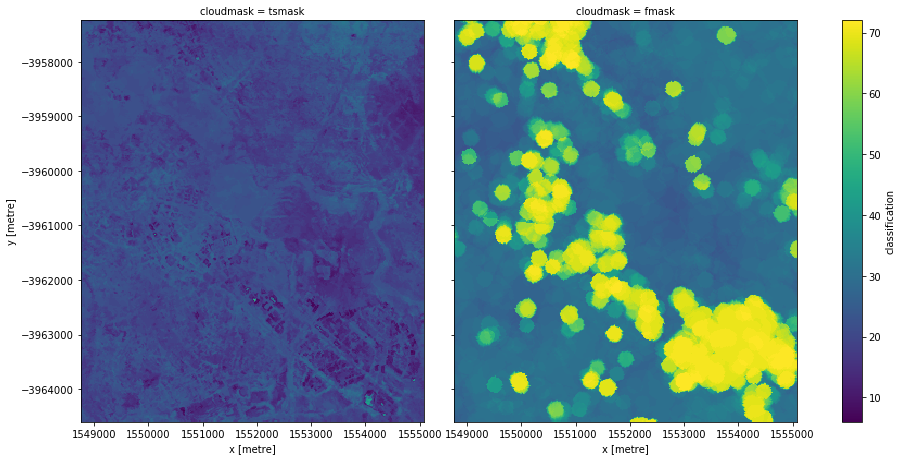

In [31]:
combined_ds = xr.concat([(tsmask_ds.classification == 3).sum(dim='time'), 
                         (s2_ds.fmask == 2).sum(dim='time')], dim='cloudmask')
combined_ds = combined_ds.assign_coords(cloudmask=['tsmask', 'fmask'])
combined_ds.plot(col='cloudmask', size=6.5, aspect=1)

## Compare cloud shadow in both datasets

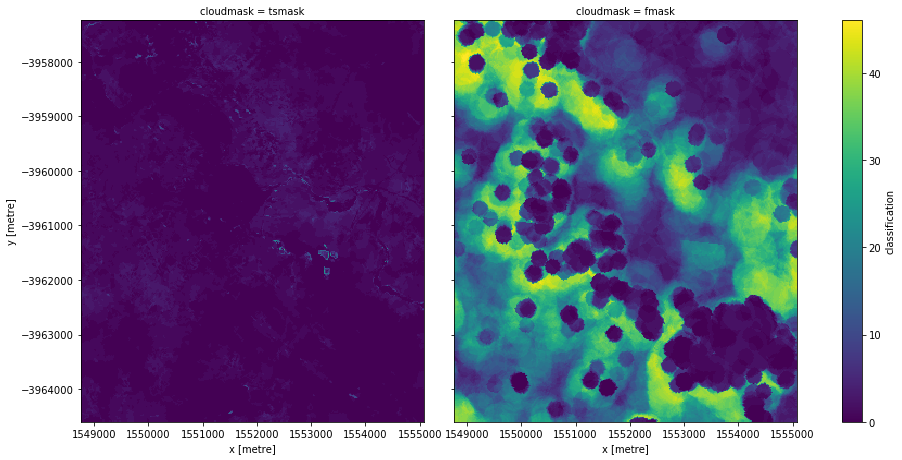

In [32]:
combined_ds = xr.concat([(tsmask_ds.classification == 2).sum(dim='time'), 
                         (s2_ds.fmask == 3).sum(dim='time')], dim='cloudmask')
combined_ds = combined_ds.assign_coords(cloudmask=['tsmask', 'fmask'])
combined_ds.plot(col='cloudmask', size=6.5, aspect=1)

## Plot example observations

### Comparing cloud masking

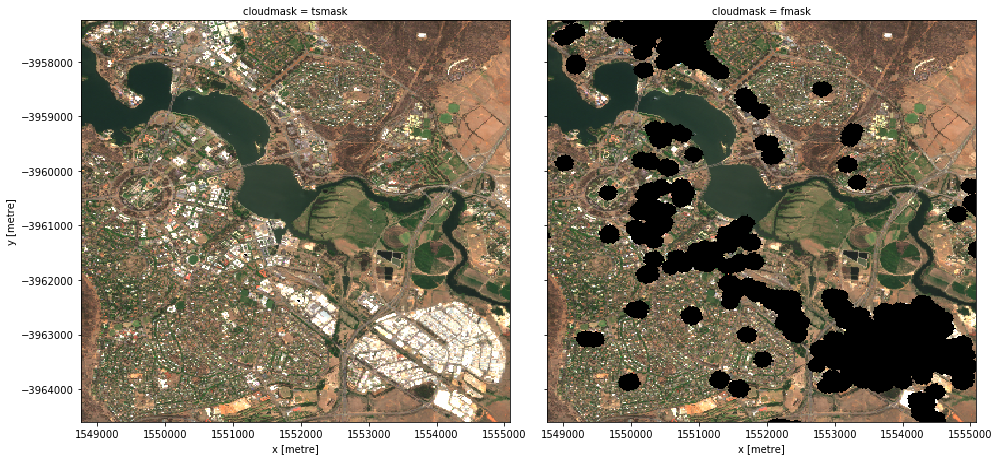

In [33]:
timestep = 13

rgb_data = s2_ds[['nbart_red', 'nbart_green', 'nbart_blue']]
combined_ds = xr.concat([rgb_data.where(tsmask_ds.classification != 3, other=0).isel(time=timestep).to_array(),
                         rgb_data.where(s2_ds.fmask != 2, other=0).isel(time=timestep).to_array()], dim='cloudmask')
combined_ds = combined_ds.assign_coords(cloudmask=['tsmask', 'fmask'])
combined_ds.plot.imshow(col='cloudmask', size=6.5, aspect=1, robust=True)


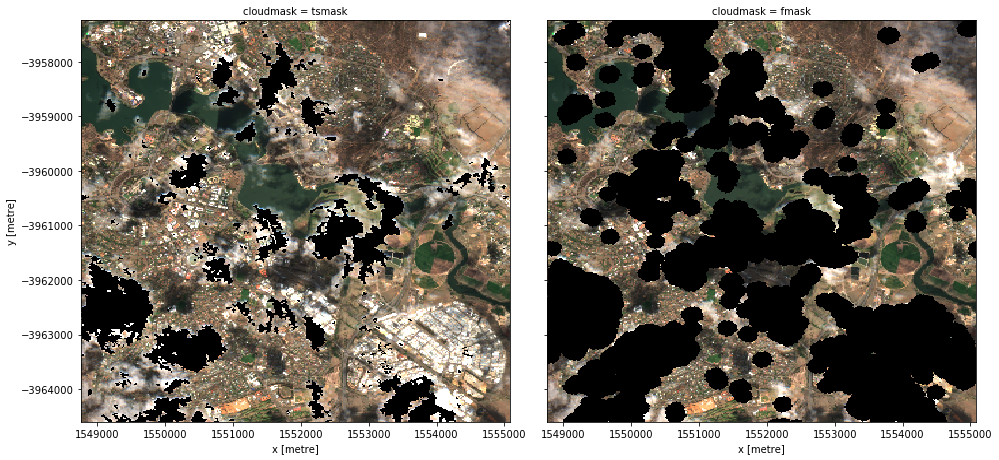

In [34]:
timestep = 8

rgb_data = s2_ds[['nbart_red', 'nbart_green', 'nbart_blue']]
combined_ds = xr.concat([rgb_data.where(tsmask_ds.classification != 3, other=0).isel(time=timestep).to_array(),
                         rgb_data.where(s2_ds.fmask != 2, other=0).isel(time=timestep).to_array()], dim='cloudmask')
combined_ds = combined_ds.assign_coords(cloudmask=['tsmask', 'fmask'])
combined_ds.plot.imshow(col='cloudmask', size=6.5, aspect=1, robust=True)

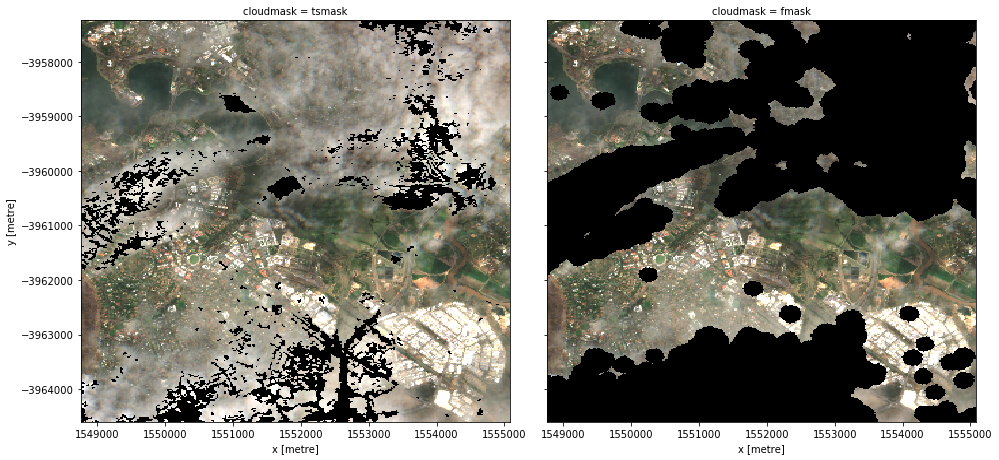

In [36]:
timestep = 22

rgb_data = s2_ds[['nbart_red', 'nbart_green', 'nbart_blue']]
combined_ds = xr.concat([rgb_data.where(tsmask_ds.classification != 3, other=0).isel(time=timestep).to_array(),
                         rgb_data.where(s2_ds.fmask != 2, other=0).isel(time=timestep).to_array()], dim='cloudmask')
combined_ds = combined_ds.assign_coords(cloudmask=['tsmask', 'fmask'])
combined_ds.plot.imshow(col='cloudmask', size=6.5, aspect=1, robust=True)

### Comparing cloud shadow masking

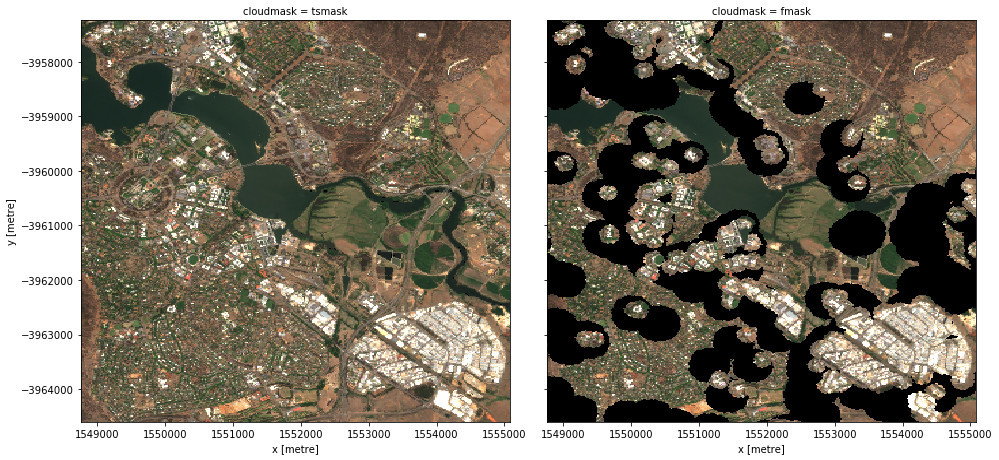

In [37]:
timestep = 13

rgb_data = s2_ds[['nbart_red', 'nbart_green', 'nbart_blue']]
combined_ds = xr.concat([rgb_data.where(tsmask_ds.classification != 2, other=0).isel(time=timestep).to_array(),
                         rgb_data.where(s2_ds.fmask != 3, other=0).isel(time=timestep).to_array()], dim='cloudmask')
combined_ds = combined_ds.assign_coords(cloudmask=['tsmask', 'fmask'])
combined_ds.plot.imshow(col='cloudmask', size=6.5, aspect=1, robust=True)


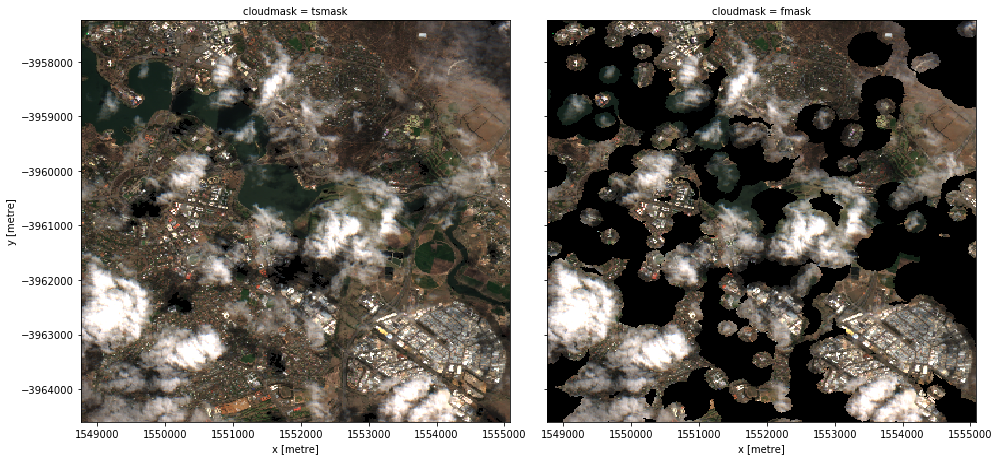

In [38]:
timestep = 8

rgb_data = s2_ds[['nbart_red', 'nbart_green', 'nbart_blue']]
combined_ds = xr.concat([rgb_data.where(tsmask_ds.classification != 2, other=0).isel(time=timestep).to_array(),
                         rgb_data.where(s2_ds.fmask != 3, other=0).isel(time=timestep).to_array()], dim='cloudmask')
combined_ds = combined_ds.assign_coords(cloudmask=['tsmask', 'fmask'])
combined_ds.plot.imshow(col='cloudmask', size=6.5, aspect=1, robust=True)

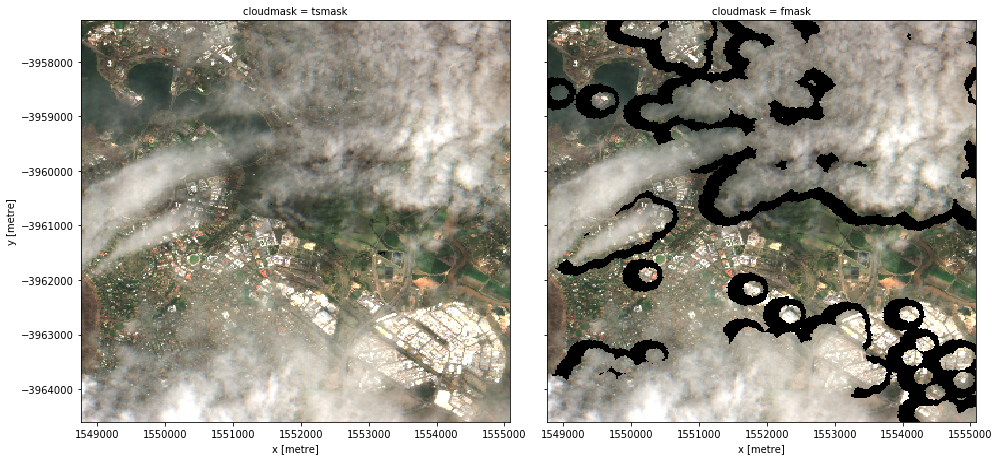

In [39]:
timestep = 22

rgb_data = s2_ds[['nbart_red', 'nbart_green', 'nbart_blue']]
combined_ds = xr.concat([rgb_data.where(tsmask_ds.classification != 2, other=0).isel(time=timestep).to_array(),
                         rgb_data.where(s2_ds.fmask != 3, other=0).isel(time=timestep).to_array()], dim='cloudmask')
combined_ds = combined_ds.assign_coords(cloudmask=['tsmask', 'fmask'])
combined_ds.plot.imshow(col='cloudmask', size=6.5, aspect=1, robust=True)